# Example of ground-aerial image matching using CVM-Net
![alt text]( ../cvm_net.PNG "CVM-Net")

In [1]:
import cvm_inference
import numpy as np
import os.path
import matplotlib.pyplot as plt
import cv2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Instance inference object

In [2]:
inference = cvm_inference.CVMInference()

VGG16: trainable = False
VGG16: trainable = False
Siamese_FC: dim_reduction  trainable = False
CVMInference object created


### Load Aerial Descriptors

In [3]:
filename = 'sat_descriptors_dubai2.npz'
if os.path.isfile(filename):
    sat_descriptors = np.load(filename)['arr_0']
    print(sat_descriptors.shape)
    print ("Found aerial descriptors file")
else:
    print ("No aerial descriptors file was found... Matching won't be possible")

(5, 4096)
Found aerial descriptors file


### Load satellite and ground images

In [4]:
ground_images = inference.load_images_raw(is_ground = True)
satellite_images = inference.load_images_raw(is_ground = False)

../Data/CVUSA/dubai2/aerial0.jpg
../Data/CVUSA/dubai2/aerial1.jpg
../Data/CVUSA/dubai2/aerial2.jpg
../Data/CVUSA/dubai2/aerial3.jpg
../Data/CVUSA/dubai2/aerial4.jpg


## Show images

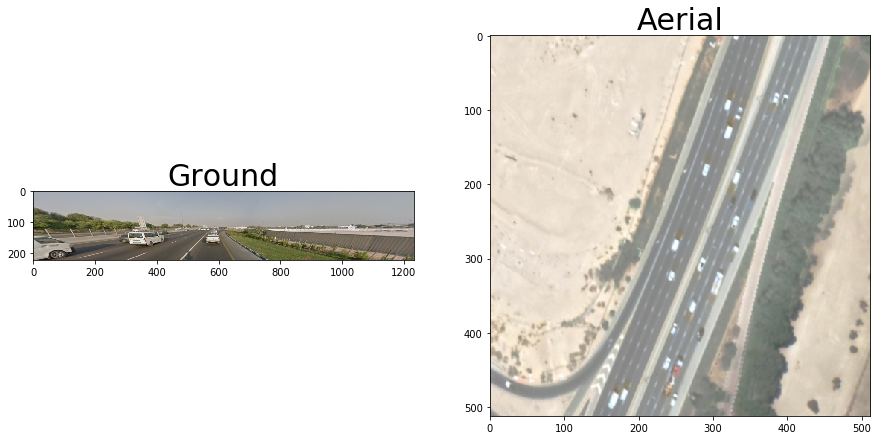

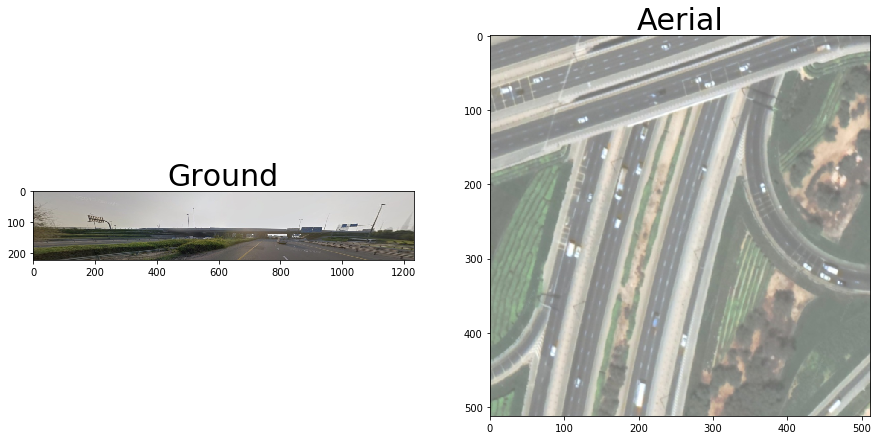

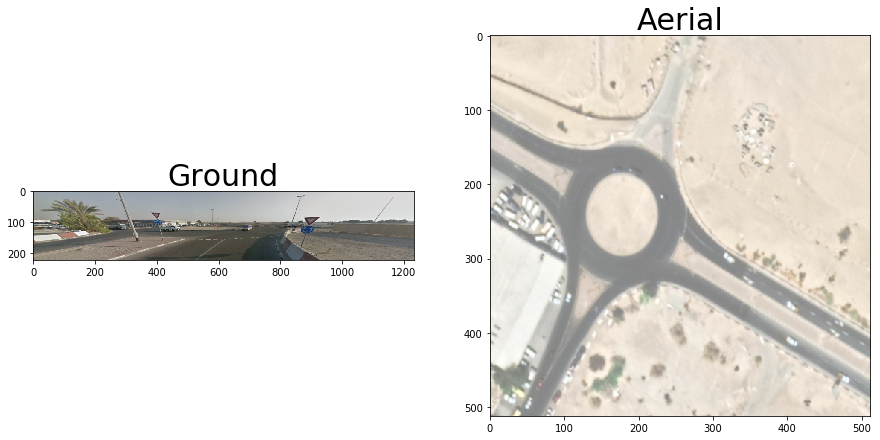

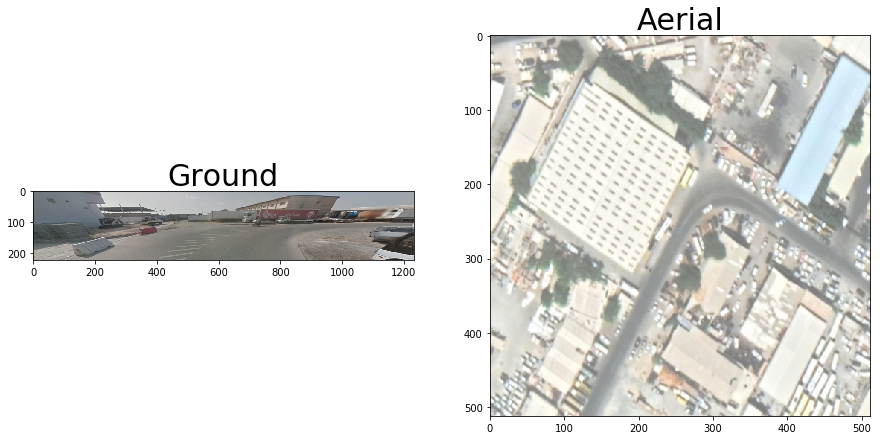

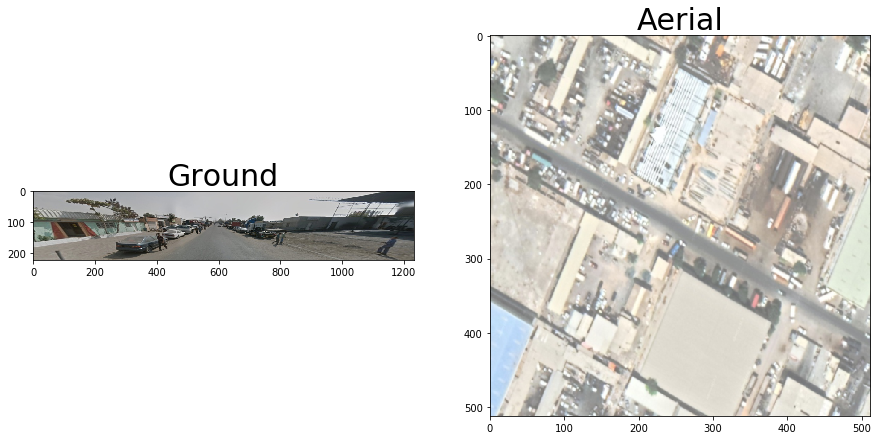

In [6]:
for i in range(5):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.imshow(ground_images[i])
    ax1.set_title('Ground', fontsize=30)
    ax2.imshow(satellite_images[i])
    ax2.set_title('Aerial', fontsize=30)
    plt.show()

### Compute descriptors of one of the ground images

In [7]:
ground_img_idx = 0
print("Extracting Descriptors from ground image, this might take some time...")
load_from_file = False
grd_filename = 'ground_descriptors_dubai2.npz'
if load_from_file:
    if os.path.isfile(filename):
        ground_descriptors = np.load(grd_filename)['arr_0']
        print(ground_descriptors.shape)
        print ("Found ground descriptors file")
    else:
        print ("No ground descriptors file was found... Try setting load_from_file to False to generate it")
else:    
    ground_descriptors = inference.forward(inference.load_images(is_ground = True), is_ground = True)
    np.savez(grd_filename, ground_descriptors)
    print(ground_descriptors.shape)
    


Extracting Descriptors from ground image, this might take some time...
loading model...
INFO:tensorflow:Restoring parameters from ../Model/CVM-NET-I/0/model.ckpt
   Model loaded from: ../Model/CVM-NET-I/0/model.ckpt
load model...FINISHED
validate...
   compute global descriptors
(5, 4096)


### Find the best matches for the ground image based on the descriptor

In [8]:
# Softmax Function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [9]:
euclidean_distances_list = []
for ground_descriptor in ground_descriptors:
    euclidian_distances = []
    for sat_descriptor in sat_descriptors:
        dist = np.linalg.norm(sat_descriptor-ground_descriptor)
        euclidian_distances.append(1/dist)
    indexes = np.arange(sat_descriptors.shape[0])
    distances_dict = dict(zip(indexes.T, softmax(euclidian_distances)))
    sorted_distances_dict = sorted(distances_dict.items(), key = lambda x:-x[1])
    sorted_distances_dict
    euclidean_distances_list.append(sorted_distances_dict)

In [10]:
print(euclidean_distances_list)

[[(0, 0.2708754640201473), (1, 0.2612410509287484), (2, 0.16750516850645644), (3, 0.15195807715497403), (4, 0.14842023938967394)], [(1, 0.33174527859715114), (0, 0.27422979651823604), (2, 0.14622546541909476), (3, 0.1239906167158051), (4, 0.1238088427497129)], [(1, 0.27819783738035986), (0, 0.261694064575248), (2, 0.19401631513303122), (4, 0.1335680441438294), (3, 0.13252373876753146)], [(1, 0.3040468212771521), (0, 0.2592750992847707), (2, 0.16275616856434774), (4, 0.14013303162815935), (3, 0.13378887924557006)], [(0, 0.2339269134747479), (1, 0.22693039995571013), (4, 0.188650624686129), (3, 0.17937443062375516), (2, 0.17111763125965782)]]


### Function to add green frame to ground truth

In [11]:
def add_frame(image, is_ground_truth = True):
    if not is_ground_truth:
        return image
    img = image.copy()
    b = 8
    c=(0,255,0)
    thickness = 10
    width, height, _ = img.shape
    p1 = (b , b)
    p2 = (b , height - b)
    p3 = (width - b , height - b)
    p4 = (width - b , b)
    cv2.line(img, p1, p2, c, thickness)
    cv2.line(img, p2, p3, c, thickness)
    cv2.line(img, p3, p4, c, thickness)
    cv2.line(img, p4, p1, c, thickness)
    return img
    


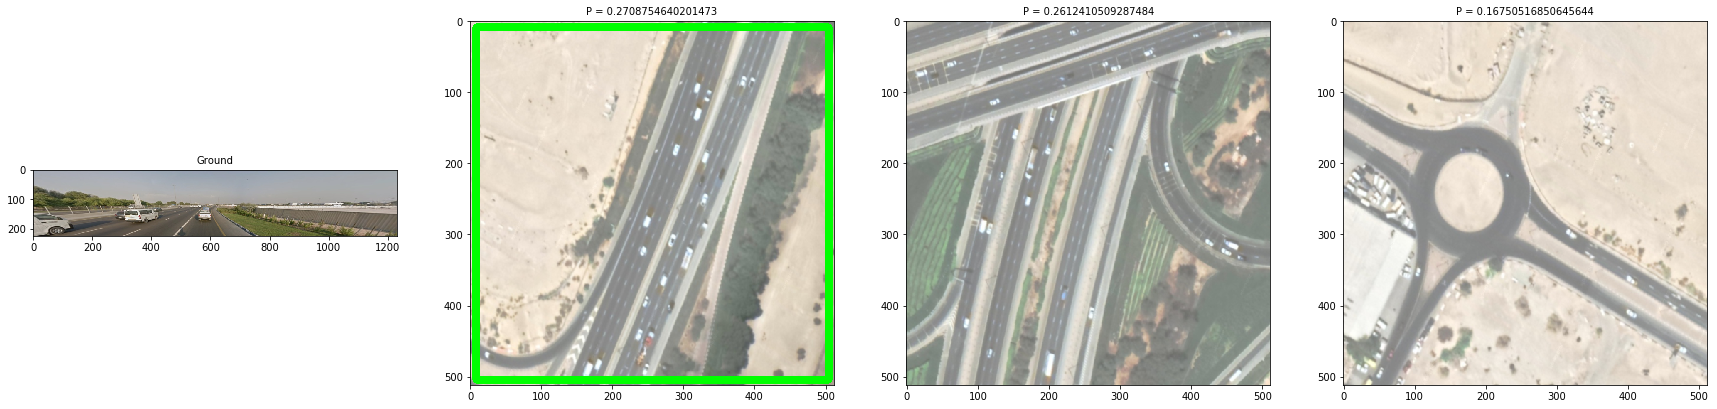

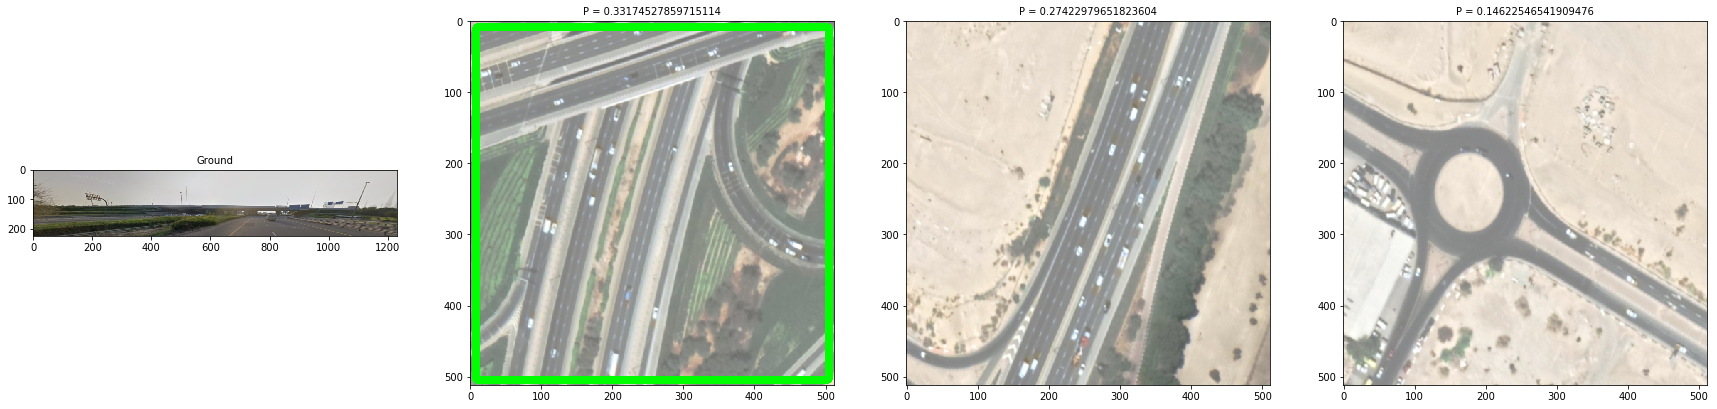

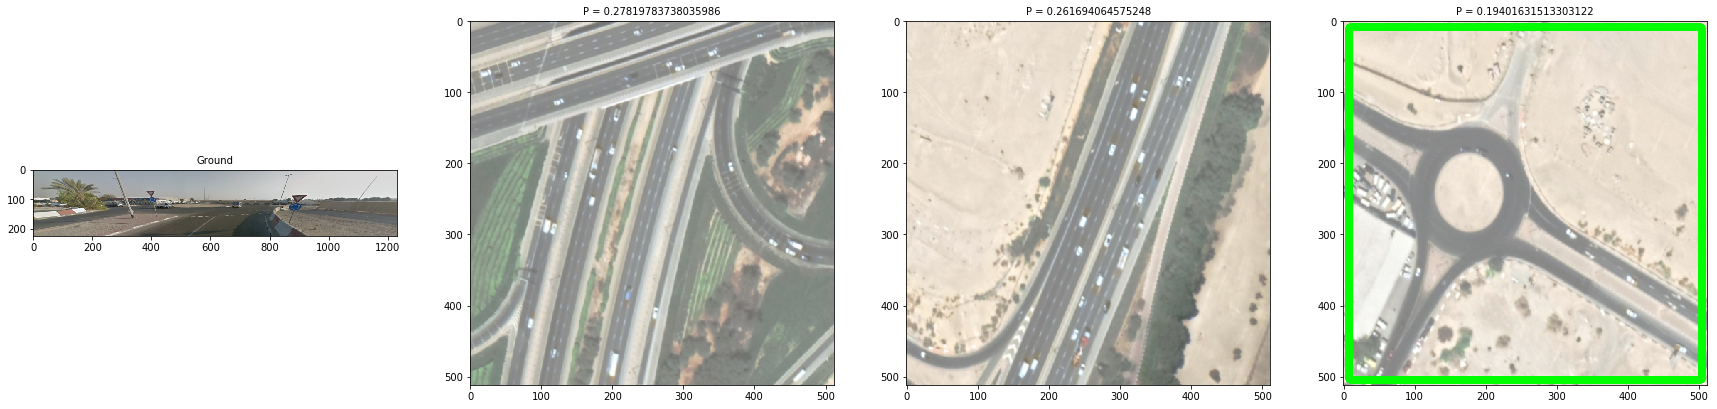

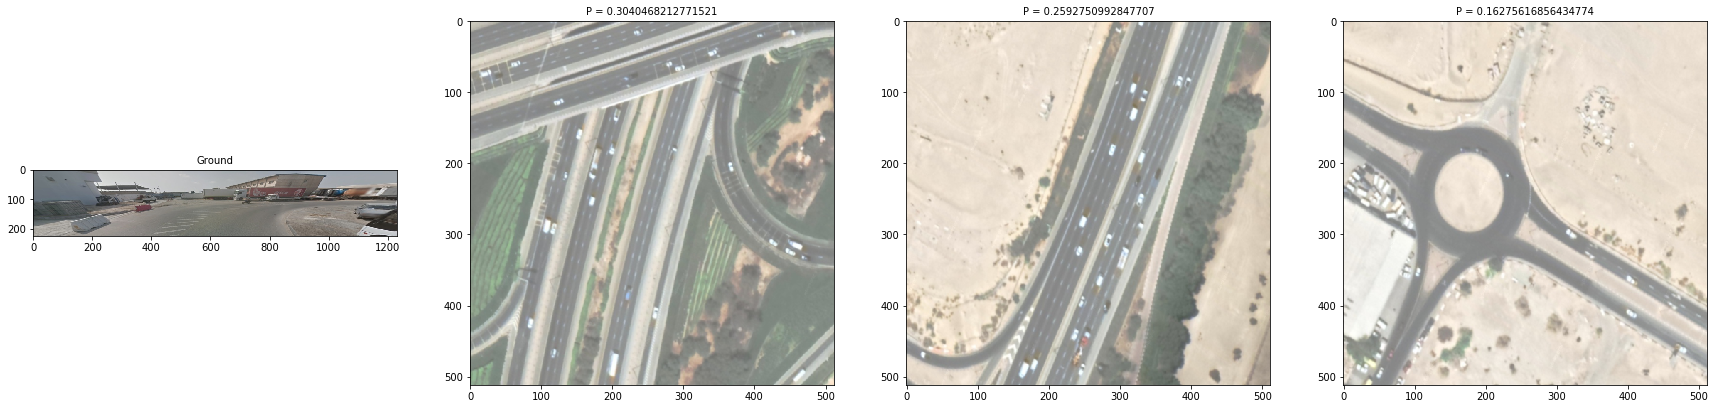

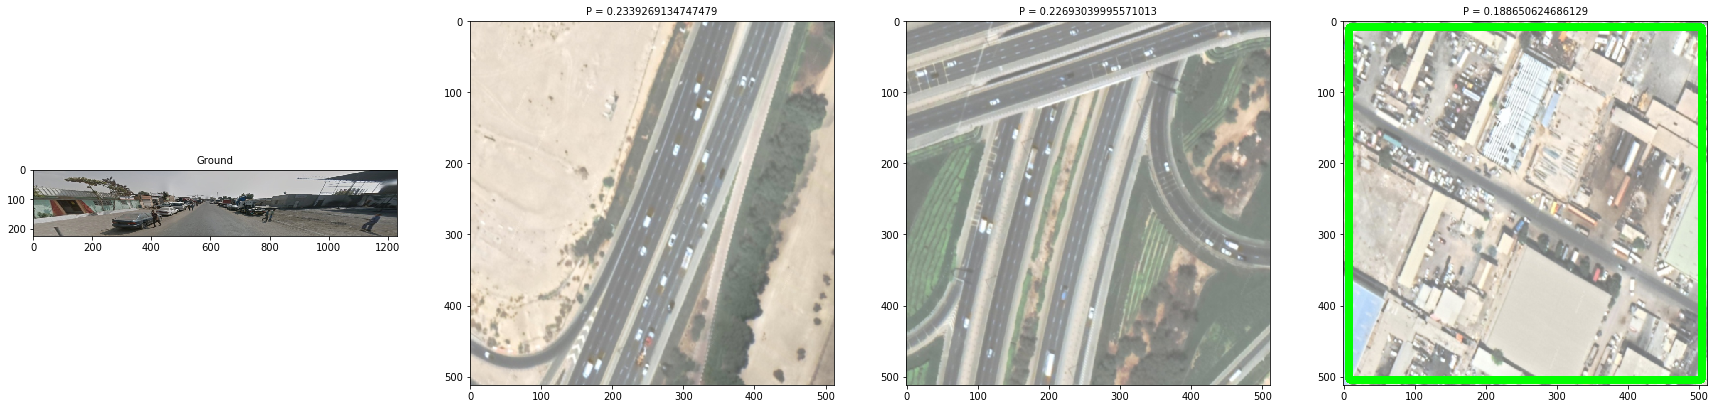

In [12]:
i = 0
for euclidian_dist in euclidean_distances_list:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,10))
    ax1.imshow(ground_images[i])
    ax1.set_title('Ground', fontsize=10)
    ax2.imshow(add_frame(satellite_images[euclidian_dist[0][0]], i == euclidian_dist[0][0]))
    ax2.set_title('P = ' + str(euclidian_dist[0][1]), fontsize=10)
    ax3.imshow(add_frame(satellite_images[euclidian_dist[1][0]], i == euclidian_dist[1][0]))
    ax3.set_title('P = ' + str(euclidian_dist[1][1]), fontsize=10)
    ax4.imshow(add_frame(satellite_images[euclidian_dist[2][0]], i == euclidian_dist[2][0]))
    ax4.set_title('P = ' + str(euclidian_dist[2][1]), fontsize=10)
    #ax5.imshow(add_frame(satellite_images[euclidian_dist[3][0]], i == euclidian_dist[3][0]))
    #ax5.set_title('P = ' + str(euclidian_dist[3][1]), fontsize=10)
    #ax6.imshow(add_frame(satellite_images[euclidian_dist[4][0]], i == euclidian_dist[4][0]))
    #ax6.set_title('P = ' + str(euclidian_dist[4][1]), fontsize=10)
    plt.show()
    i += 1